<a href="https://colab.research.google.com/github/verneh/animate/blob/main/animate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Animate with cartoonified version. Run this wigh GPU.


In [1]:
# load from drive.
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# confirm version of tensorflow.
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
# clone to drive.
%cd '/content/gdrive/MyDrive/stylegan2'
!git clone https://github.com/justinpinkney/stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

/content/gdrive/MyDrive/stylegan2
Cloning into 'stylegan2'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 2.32 MiB | 17.20 MiB/s, done.
Resolving deltas: 100% (141/141), done.
CPU says hello.
GPU says hello.


In [4]:
# create directory.
!mkdir '/content/gdrive/MyDrive/stylegan2/raw'
!mkdir '/content/gdrive/MyDrive/stylegan2/aligned'
!mkdir '/content/gdrive/MyDrive/stylegan2/generated'

mkdir: cannot create directory ‘/content/gdrive/MyDrive/stylegan2/raw’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/stylegan2/aligned’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/stylegan2/generated’: File exists


In [5]:
# because i'm a fan of the french football player mbappe. let's grab mbappe's image.
!wget https://tmssl.akamaized.net/images/portrait/originals/342229-1602849394.jpg -O /content/gdrive/MyDrive/stylegan2/raw/example.jpg

--2021-04-20 11:20:15--  https://tmssl.akamaized.net/images/portrait/originals/342229-1602849394.jpg
Resolving tmssl.akamaized.net (tmssl.akamaized.net)... 23.62.230.71, 23.62.230.93, 2600:1408:5400:5::170c:902d, ...
Connecting to tmssl.akamaized.net (tmssl.akamaized.net)|23.62.230.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235891 (230K) [image/jpeg]
Saving to: ‘/content/gdrive/MyDrive/stylegan2/raw/example.jpg’

/content/gdrive/MyD 100%[===================>] 230.36K   458KB/s    in 0.5s    

2021-04-20 11:20:17 (458 KB/s) - ‘/content/gdrive/MyDrive/stylegan2/raw/example.jpg’ saved [235891/235891]



In [6]:
# confirm which drive we are at the moment.
!pwd

/content/gdrive/My Drive/stylegan2


In [7]:
# change directory so we can run scripts.
import os
os.chdir('/content/gdrive/MyDrive/stylegan2')

In [8]:
import pretrained_networks

# original blended model found here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
blended_url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU" 
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [9]:
# align images.
!python align_images.py raw aligned

64045056/64040097 [==============================] - 1s 0us/step


In [10]:
# generate image
!python project_images.py --num-steps 500 aligned generated

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "example_01.png"...


In [11]:
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))


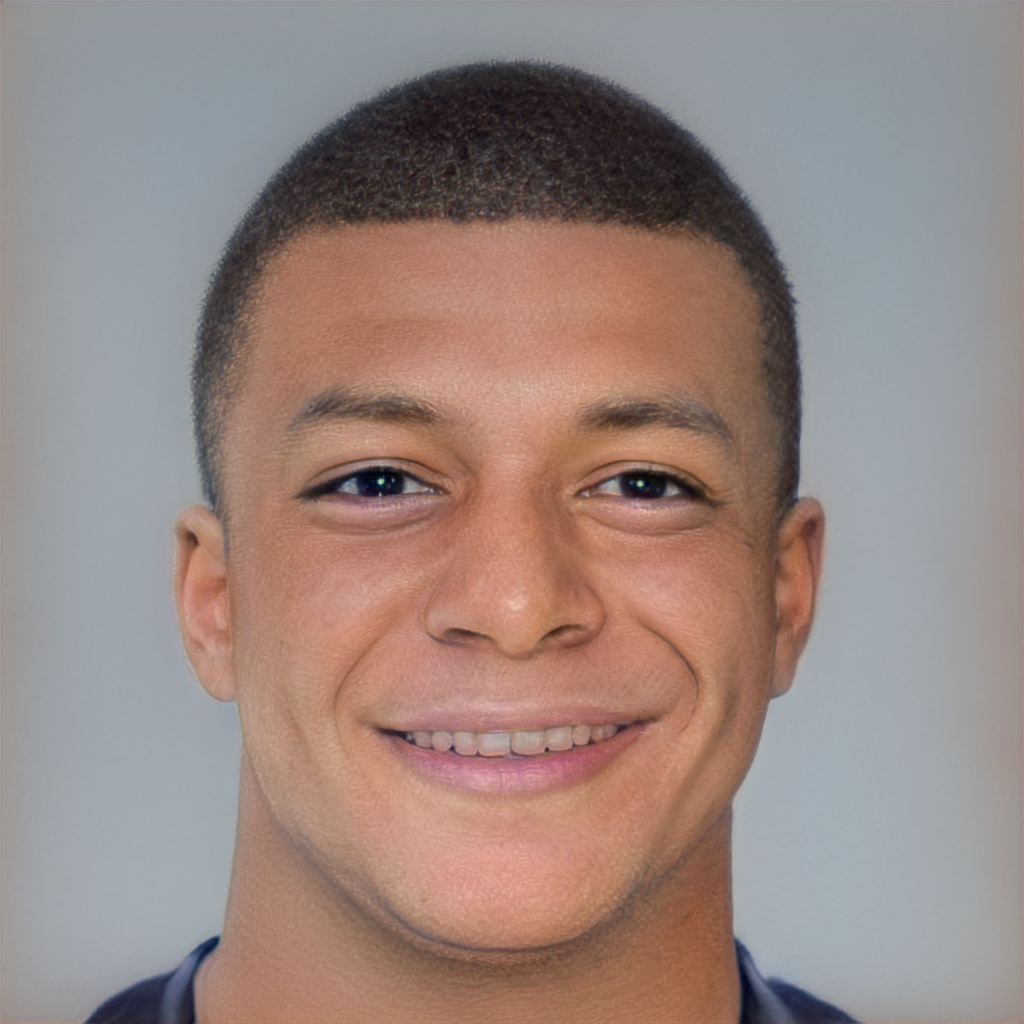

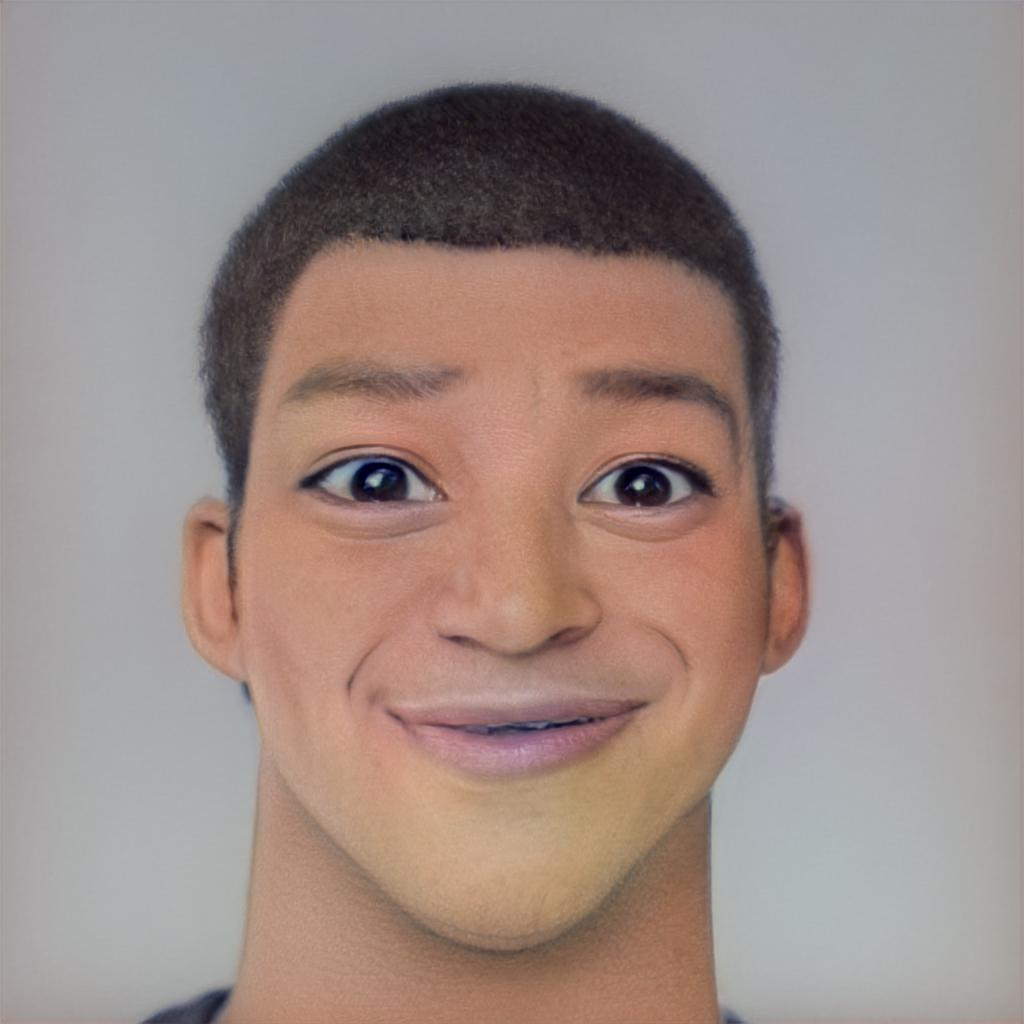

In [12]:
# comparison of original and generated image.
from IPython.display import Image 
embedded = Image(filename="generated/example_01.png", width=256)
display(embedded)
tooned = Image(filename="generated/example_01-toon.jpg", width=256)
display(tooned)

In [ ]:
# we grab first order model.
!git clone https://github.com/AliaksandrSiarohin/first-order-model

Set up a path, so we do not need to change directory

In [14]:
try: # set up path
    import sys
    sys.path.append('/content/gdrive/MyDrive/stylegan2/first-order-model')
    print('Path added')
except Exception as e:
    print(e)
    pass

Path added


In [ ]:
# download pretrained weights for keypoint detector and video generator. had to manually download this and store within google drive.
!wget "https://drive.google.com/uc?export=download&id=1jmcn19-c3p8mf39aYNXUhdMqzqDYZhQ_" -O vox-cpk.pth.tar

--2021-04-16 20:20:07--  https://drive.google.com/uc?export=download&id=1jmcn19-c3p8mf39aYNXUhdMqzqDYZhQ_
Resolving drive.google.com (drive.google.com)... 172.217.12.238, 2607:f8b0:4004:807::200e
Connecting to drive.google.com (drive.google.com)|172.217.12.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘vox-cpk.pth.tar’

vox-cpk.pth.tar         [ <=>                ]   3.20K  --.-KB/s    in 0s      

2021-04-16 20:20:07 (37.6 MB/s) - ‘vox-cpk.pth.tar’ saved [3277]



In [15]:
# Load model.
from demo import load_checkpoints
generator, kp_detector = load_checkpoints(config_path='first-order-model/config/vox-256.yaml', checkpoint_path='vox-cpk.pth.tar')

In [16]:
# we're going to use trump for this instance.
!wget https://drive.google.com/uc?id=1d1JUp3SrQlB-S11oHdRXNLzlVaTgG5bZ -O src_video.mp4

# Some other videos
# https://drive.google.com/uc?id=19F7ambg3osMEBapOZayZ07RaDI_ij9OS
# https://drive.google.com/uc?id=1LjDoFmeP0hZQSsUmnou0UbQJJzQ8rMLR
# 
# 


--2021-04-20 11:32:47--  https://drive.google.com/uc?id=1d1JUp3SrQlB-S11oHdRXNLzlVaTgG5bZ
Resolving drive.google.com (drive.google.com)... 142.250.73.238, 2607:f8b0:4004:82a::200e
Connecting to drive.google.com (drive.google.com)|142.250.73.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7751o1jk1v9g9fv56je5jf3v97o4b95h/1618918350000/06117322118322238542/*/1d1JUp3SrQlB-S11oHdRXNLzlVaTgG5bZ [following]
--2021-04-20 11:32:48--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7751o1jk1v9g9fv56je5jf3v97o4b95h/1618918350000/06117322118322238542/*/1d1JUp3SrQlB-S11oHdRXNLzlVaTgG5bZ
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 172.217.13.65, 2607:f8b0:4004:808::2001
Connecting to doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)|172.217.13.65|:4

In [20]:
# generate animation with the original image.
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML

from demo import make_animation
from skimage import img_as_ubyte

import warnings
warnings.filterwarnings("ignore")

source_image = imageio.imread('/content/gdrive/MyDrive/stylegan2/generated/example_01.png')
reader = imageio.get_reader('/content/gdrive/MyDrive/stylegan2/src_video.mp4')


#Resize image and video to 256x256

source_image = resize(source_image, (256, 256))[..., :3]

fps = reader.get_meta_data()['fps']
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()

driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

# Generate animation
predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)

def display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    

HTML(display(source_image, driving_video, predictions).to_html5_video())

100%|██████████| 211/211 [00:08<00:00, 25.69it/s]


In [22]:
# generate animation with the toonified image.
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML

from demo import make_animation
from skimage import img_as_ubyte

import warnings
warnings.filterwarnings("ignore")

source_image = imageio.imread('/content/gdrive/MyDrive/stylegan2/generated/example_01-toon.jpg')
reader = imageio.get_reader('/content/gdrive/MyDrive/stylegan2/src_video.mp4')


#Resize image and video to 256x256

source_image = resize(source_image, (256, 256))[..., :3]

fps = reader.get_meta_data()['fps']
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()

driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

# Generate animation
predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)

def display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    

HTML(display(source_image, driving_video, predictions).to_html5_video())

100%|██████████| 211/211 [00:08<00:00, 25.44it/s]
